<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/ANL488_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries




In [1]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4027    0  4027    0     0   2567      0 --:--:--  0:00:01 --:--:--  2566
100  517k  100  517k    0     0   233k      0  0:00:02  0:00:02 --:--:--  233k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4031    0  4031    0     0   8262      0 --:--:-- --:--:-- --:--:--  8277
100  392k  100  392k    0     0   345k      0  0:00:01  0:00:01 --:--:-- 2515k


# Step 2: Download data and prepare main dataframe


In [2]:
# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Step 3: Adding technical indicators using TA-Lib

In [3]:
# Adding Technical Indicators using TA-Lib

# Calculate Relative Strength Index (RSI)
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate Volume Weighted Average Price (VWAP)
data['VWAP'] = (data['Adj Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Step 4: Create lag features

In [4]:
# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'EMA_KC', 'KC_upper', 'KC_lower',
                   'DC_upper', 'DC_lower', 'DC_middle','VWAP','OBV','CMF','stoch_k','stoch_d','ADX']

# Number of lag days to create
lag_days = 20

# Function to create lagged features
def create_lagged_features(df, lag_days, columns):
    for col in columns:
        for lag in range(1, lag_days + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lag_days, features_to_lag)
data.dropna(inplace=True)

# Check the resulting DataFrame to confirm new columns
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-20  140.050003  140.610001  139.639999  140.440002  111.839790   
2012-03-21  140.520004  140.649994  139.919998  140.210007  111.656586   
2012-03-22  139.179993  139.550003  138.740005  139.199997  110.852318   
2012-03-23  139.320007  139.809998  138.550003  139.649994  111.210655   
2012-03-26  140.649994  141.610001  140.600006  141.610001  112.771515   

               Volume        RSI      MACD  MACD_signal  MACD_diff  ...  \
Date                                                                ...   
2012-03-20  121729700  71.356826  1.443671     1.252664   0.191007  ...   
2012-03-21  122388400  69.496737  1.432612     1.288654   0.143959  ...   
2012-03-22  135216700  61.871747  1.343464     1.299616   0.043848  ...   
2012-03-23  120521000  63.778596  1.286894     1.297071  -0.010178  ...   
2012-03-26  120164000  70.66139

In [5]:
# Drop features that are not lagged
columns_to_drop = ['Open','High','Low','Close','Volume', 'RSI', 'MACD',
                   'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'EMA_KC', 'KC_upper', 'KC_lower','DC_upper',
                   'DC_lower', 'DC_middle','VWAP','OBV','CMF','Money_Flow_Multiplier',
                   'Money_Flow_Volume','stoch_k','stoch_d','ADX']

data.drop(columns=columns_to_drop, inplace=True)
data.fillna(method='ffill', inplace=True)

# Step 6: Split the data into train, validation, and test sets

In [6]:
# Split into training, validation, and test sets
train_data = data[data.index < "2022-01-01"]
validation_data = data[(data.index >= "2022-01-01") & (data.index < "2023-01-01")]
test_data = data[data.index >= "2023-01-01"]

# Display the sizes of each set to ensure proper segregation
print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2464, 421)
Validation set: (251, 421)
Test set: (250, 421)


# Step 7: Identify important features using RandomForest

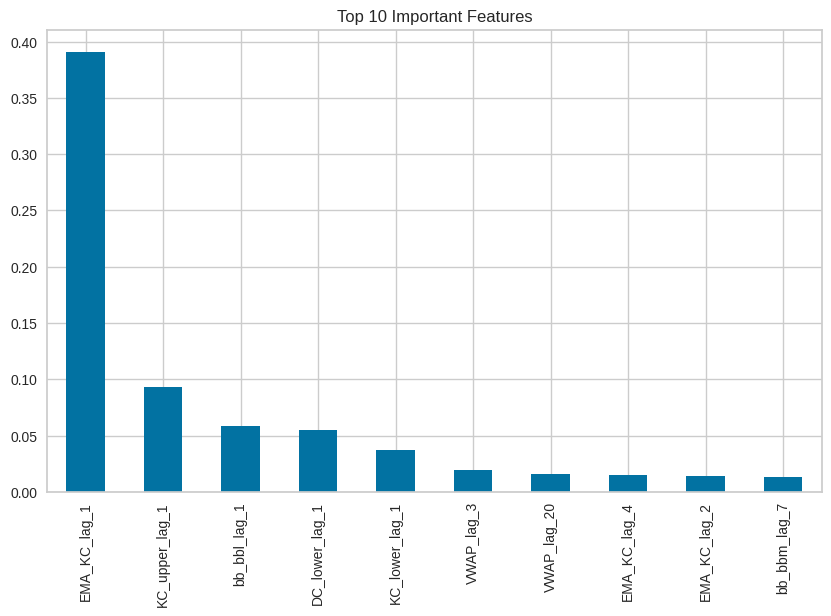

['EMA_KC_lag_1',
 'KC_upper_lag_1',
 'bb_bbl_lag_1',
 'DC_lower_lag_1',
 'KC_lower_lag_1',
 'VWAP_lag_3',
 'VWAP_lag_20',
 'EMA_KC_lag_4',
 'EMA_KC_lag_2',
 'bb_bbm_lag_7',
 'VWAP_lag_17',
 'VWAP_lag_7',
 'VWAP_lag_2',
 'KC_upper_lag_2',
 'VWAP_lag_16',
 'bb_bbm_lag_5',
 'VWAP_lag_18',
 'VWAP_lag_10',
 'VWAP_lag_14',
 'bb_bbh_lag_14',
 'bb_bbh_lag_20',
 'EMA_KC_lag_5',
 'VWAP_lag_8',
 'VWAP_lag_13',
 'KC_lower_lag_15',
 'VWAP_lag_4',
 'VWAP_lag_19',
 'VWAP_lag_15',
 'bb_bbm_lag_20',
 'VWAP_lag_12',
 'VWAP_lag_6',
 'OBV_lag_1']

In [7]:
X_train = train_data.drop(columns=['Adj Close'])
y_train = train_data['Adj Close']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Identify important features (features with importance > 0.005, contributes at least 0.5% to the model's predictive ability)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.005].index.tolist()

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.show()

# Show the selected features
selected_features

In [8]:
# Use only the selected features
train_data_selected = train_data[selected_features + ['Adj Close']]
validation_data_selected = validation_data[selected_features + ['Adj Close']]
test_data_selected = test_data[selected_features + ['Adj Close']]

# Step 8: Setup regression model using PyCaret

In [9]:
# Setup regression model using PyCaret for predicting returns
regression_setup = setup(
    data=train_data_selected,
    target='Adj Close',
    fold_strategy='timeseries',  # Time series cross-validation
    fold=5,                      # Use 5 folds for cross-validation
    session_id=42,
    use_gpu=False,
    data_split_shuffle=False,    # Ensure data is not shuffled
    fold_shuffle=False           # Ensure folds are not shuffled
)

,Description,Value
0,Session id,42
1,Target,Adj Close
2,Target type,Regression
3,Original data shape,"(2464, 33)"
4,Transformed data shape,"(2464, 33)"
5,Transformed train set shape,"(1724, 33)"
6,Transformed test set shape,"(740, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


# Step 9: Compare models and select the top 3

In [10]:
# Compare different models
best_model = compare_models(n_select=3, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.1977,3.0805,1.6579,0.9549,0.0088,0.0064,0.0340
llar,Lasso Least Angle Regression,2.8648,13.9901,3.5581,0.7713,0.0189,0.0154,0.1140
en,Elastic Net,2.9725,13.6400,3.5947,0.8087,0.0187,0.0156,0.0480
lasso,Lasso Regression,2.9715,14.0387,3.6245,0.7775,0.0192,0.0159,0.0500
omp,Orthogonal Matching Pursuit,8.5457,189.3035,9.3579,-1.5727,0.0555,0.0484,0.0380
rf,Random Forest Regressor,13.4673,276.8848,15.7082,-1.8504,0.0846,0.0695,1.8880
et,Extra Trees Regressor,13.6726,287.0151,15.9369,-1.9082,0.0857,0.0705,0.6800
ada,AdaBoost Regressor,14.1701,300.0274,16.2436,-2.1297,0.0868,0.0724,0.5780
xgboost,Extreme Gradient Boosting,14.0649,301.5796,16.2868,-2.0543,0.0877,0.0724,0.4280
gbr,Gradient Boosting Regressor,14.2617,296.1897,16.4192,-2.1202,0.0887,0.0738,1.0780


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

# Step 10: Evaluate models using the validation set







In [11]:
# Evaluate the models on the validation set
validation_X = validation_data_selected.drop(columns=['Adj Close'])
validation_y = validation_data_selected['Adj Close']

evaluated_models = []
for model in best_model:
    # Evaluate the model directly on validation data without finalizing
    validation_predictions = predict_model(model, data=validation_X)
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions['prediction_label']))
    val_r2 = r2_score(validation_y, validation_predictions['prediction_label'])

    print(f"Initial Validation RMSE for model {model}: {val_rmse}")
    print(f"Initial Validation R² Score for model {model}: {val_r2}")

    evaluated_models.append((model, val_rmse, val_r2))

# Select the best model(s) based on the lowest RMSE
evaluated_models.sort(key=lambda x: x[1])  # Sort by RMSE in ascending order
top_models = [model[0] for model in evaluated_models[:3]]  # Select top 3 models based on RMSE

Initial Validation RMSE for model Ridge(random_state=42): 5.955875906895802
Initial Validation R² Score for model Ridge(random_state=42): 0.9499056088046681


Initial Validation RMSE for model LassoLars(random_state=42): 11.320573310875492
Initial Validation R² Score for model LassoLars(random_state=42): 0.8190182993031738


Initial Validation RMSE for model ElasticNet(random_state=42): 9.758051344679021
Initial Validation R² Score for model ElasticNet(random_state=42): 0.8655304288370684


In [12]:
# Filter out DummyRegressor from top models
top_models = [model for model in top_models if model.__class__.__name__ != 'DummyRegressor']

# Check if there are models left to tune
if not top_models:
    print("No models left to tune after removing DummyRegressor. Please select more advanced models.")
else:
    # Fine-tune the remaining models
    tuned_models = [tune_model(model, optimize='RMSE', fold=5) for model in top_models]


# Fine-tune the selected models using PyCaret's tune_model
tuned_models = [tune_model(model, optimize='RMSE', fold=5) for model in top_models]  # Tune the top models

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9795,1.4689,1.2120,0.9831,0.0084,0.0067
1,1.1997,3.1842,1.7844,0.9151,0.0104,0.0070
2,1.2885,3.0176,1.7371,0.9585,0.0101,0.0074
3,0.9994,1.5244,1.2347,0.9905,0.0058,0.0047
4,1.8258,7.3782,2.7163,0.9153,0.0112,0.0075
Mean,1.2586,3.3147,1.7369,0.9525,0.0092,0.0067
Std,0.3069,2.1554,0.5457,0.0322,0.0019,0.0010


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8353,4.6725,2.1616,0.9462,0.0145,0.0124
1,3.3171,14.6579,3.8286,0.6094,0.0220,0.0191
2,2.6595,10.3819,3.2221,0.8572,0.0185,0.0152
3,3.2206,12.8008,3.5778,0.9203,0.0167,0.0151
4,3.1936,20.2978,4.5053,0.7669,0.0186,0.0132
Mean,2.8452,12.5622,3.4591,0.8200,0.0181,0.0150
Std,0.5549,5.1243,0.7726,0.1221,0.0025,0.0023


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7740,1.0434,1.0214,0.9880,0.0071,0.0054
1,1.2766,3.0786,1.7546,0.9180,0.0102,0.0074
2,1.2628,2.8811,1.6974,0.9604,0.0098,0.0073
3,0.8678,1.2401,1.1136,0.9923,0.0053,0.0041
4,1.7826,6.8902,2.6249,0.9209,0.0109,0.0074
Mean,1.1928,3.0267,1.6424,0.9559,0.0086,0.0063
Std,0.3580,2.1013,0.5738,0.0317,0.0021,0.0013


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9795,1.4689,1.2120,0.9831,0.0084,0.0067
1,1.1997,3.1842,1.7844,0.9151,0.0104,0.0070
2,1.2885,3.0176,1.7371,0.9585,0.0101,0.0074
3,0.9994,1.5244,1.2347,0.9905,0.0058,0.0047
4,1.8258,7.3782,2.7163,0.9153,0.0112,0.0075
Mean,1.2586,3.3147,1.7369,0.9525,0.0092,0.0067
Std,0.3069,2.1554,0.5457,0.0322,0.0019,0.0010


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8353,4.6725,2.1616,0.9462,0.0145,0.0124
1,3.3171,14.6579,3.8286,0.6094,0.0220,0.0191
2,2.6595,10.3819,3.2221,0.8572,0.0185,0.0152
3,3.2206,12.8008,3.5778,0.9203,0.0167,0.0151
4,3.1936,20.2978,4.5053,0.7669,0.0186,0.0132
Mean,2.8452,12.5622,3.4591,0.8200,0.0181,0.0150
Std,0.5549,5.1243,0.7726,0.1221,0.0025,0.0023


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7740,1.0434,1.0214,0.9880,0.0071,0.0054
1,1.2766,3.0786,1.7546,0.9180,0.0102,0.0074
2,1.2628,2.8811,1.6974,0.9604,0.0098,0.0073
3,0.8678,1.2401,1.1136,0.9923,0.0053,0.0041
4,1.7826,6.8902,2.6249,0.9209,0.0109,0.0074
Mean,1.1928,3.0267,1.6424,0.9559,0.0086,0.0063
Std,0.3580,2.1013,0.5738,0.0317,0.0021,0.0013


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
# Finalize each of the tuned models
final_models = [finalize_model(model) for model in tuned_models]

#Step 11: Test the models and generate error plots

Testing Model 1: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['EMA_KC_lag_1', 'KC_upper_lag_1',
                                             'bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'KC_lower_lag_1', 'VWAP_lag_3',
                                             'VWAP_lag_20', 'EMA_KC_lag_4',
                                             'EMA_KC_lag_2', 'bb_bbm_lag_7',
                                             'VWAP_lag_17', 'VWAP_lag_7',
                                             'VWAP_lag_2', 'KC_upper_lag_2',
                                             'VWAP_lag_16', 'bb_bbm_lag_5',
                                             'VWAP_lag_18', 'VW...
                                             'KC_lower_lag_15', 'VWAP_lag_4',
                                             'VWAP_lag_19', 'VWAP_lag_15',
                                             'bb_bbm_lag_20', 'VWAP_lag

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,57.7189,3523.7812,59.3614,-5.0849,0.1495,0.1362


Model 1 - Test RMSE: 59.3614433330496, Test R² Score: -5.084874253235581
Testing Model 2: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['EMA_KC_lag_1', 'KC_upper_lag_1',
                                             'bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'KC_lower_lag_1', 'VWAP_lag_3',
                                             'VWAP_lag_20', 'EMA_KC_lag_4',
                                             'EMA_KC_lag_2', 'bb_bbm_lag_7',
                                             'VWAP_lag_17', 'VWAP_lag_7',
                                             'VWAP_lag_2', 'KC_upper_lag_2',
                                             'VWAP_lag_16', 'bb_bbm_lag_5',
                                             'VWAP_lag_18', 'VW...
                                             'VWAP_lag_19', 'VWAP_lag_15',
                                             'bb_bbm_lag_20', 'VWAP_lag_12',

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.1829,41.6490,6.4536,0.9281,0.0153,0.0124


Model 2 - Test RMSE: 6.4536000191869105, Test R² Score: 0.9280804776704858
Testing Model 3: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['EMA_KC_lag_1', 'KC_upper_lag_1',
                                             'bb_bbl_lag_1', 'DC_lower_lag_1',
                                             'KC_lower_lag_1', 'VWAP_lag_3',
                                             'VWAP_lag_20', 'EMA_KC_lag_4',
                                             'EMA_KC_lag_2', 'bb_bbm_lag_7',
                                             'VWAP_lag_17', 'VWAP_lag_7',
                                             'VWAP_lag_2', 'KC_upper_lag_2',
                                             'VWAP_lag_16', 'bb_bbm_lag_5',
                                             'VWAP_lag_18', 'VW...
                                             'KC_lower_lag_15', 'VWAP_lag_4',
                                             'VWAP_lag_19', 'VWAP_lag_1

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.0718,15.2774,3.9086,0.9736,0.0094,0.0074


Model 3 - Test RMSE: 3.9086298853181525, Test R² Score: 0.9736189668021816


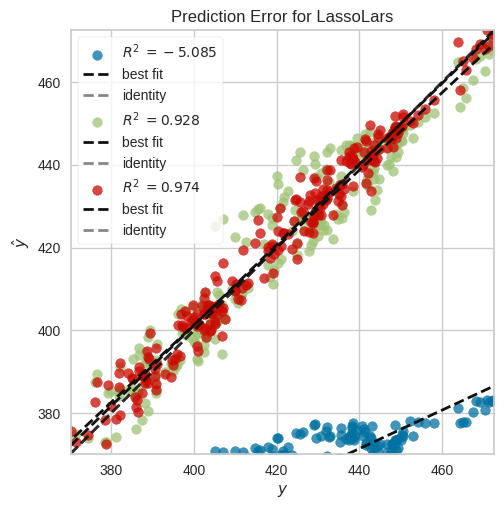

In [14]:
# Evaluate the finalized models on the test set
for i, model in enumerate(final_models, start=1):
    print(f"Testing Model {i}: {model}")

    # Make predictions on the test set
    predictions = predict_model(model, data=test_data_selected)

    # Calculate RMSE and R² score on the test set
    rmse = np.sqrt(mean_squared_error(test_data_selected['Adj Close'], predictions['prediction_label']))
    r2 = r2_score(test_data_selected['Adj Close'], predictions['prediction_label'])
    print(f"Model {i} - Test RMSE: {rmse}, Test R² Score: {r2}")

    # Plot the prediction error using Yellowbrick
    visualizer = PredictionError(model)
    visualizer.score(test_data_selected[selected_features], test_data_selected['Adj Close'])
    visualizer.show(outpath=f'prediction_error_model_{i}.png')  # Save the plot as a PNG file